# Welcome to our simple sea ice model

Zu diesem Jupyter Notebook: Code führt ihr aus indem ihr auf eine code Zelle klickt und anschließend auf den pfeil (run) in der kopfzeile. Das führt nur diese eine Zelle aus! Unter Cell/Run All könnt ihr das ganze notebook ausführen (empholen). Unter den Code-zellen werden dann die Ergebnisse, (z.b. Abbildungen) oder Fehlermeldungen angezeigt. Ihr könnt alles verändern und damit auch leicht Fehler in den code einbauen. Das wird passieren und ist beabsichtigt, programieren besteht gefühlt zu 90% daraus Fehler zu finden und zu korrigieren. Lasst euch nicht (zu sehr) ärgern. Um Änderungen rückgängig machen zu können denkt daran zu speichern immer wenn etwas funktioniert, sodass ihr mit File/revert to checkpoint diese wiederherstellen könnt. Falls gar nichts mehr geht könnt ihr den originalen link neu öffenen und kommt wieder zu der uhrsprünglichen version.

Wir verwenden die Wärmebilanz an der Oberfläche und Unterseite des Eises um Veränderungen (insbesondere der Eisdicke) zu bestimmen. Das bedeutet, dass wir vor allem die kurzwellige Sonneneinstrahlung (short wave radiation) und langwellige thermische Strahlung (long wave radiation) sowie die den Wärmefluss an der Unterseite (ocean heat flux) 'kennen' müssen. Außerdem schreiben wir vor wie viel Schnee über das Jahr hinweg fällt. Das Eis und der Schnee werden jeweils als eine homogene Schicht dargestellt (wie auf der linken Seite der folgenden Abbildung), sodass sich die Temperatur mit der tiefe durch zwei gerade linien beschreiben lässt.

![](https://www.researchgate.net/publication/319631226/figure/fig1/AS:537617779642368@1505189475441/Schematic-demonstrating-the-evolution-of-a-the-old-zero-layer-ice-thermodynamics_W640.jpg)

Falls ihr text in diesem Notebook schreiben wollt gehört der entweder in Zellen die als 'Markdown' makiert sind (wie diese) oder bei kurzen Kommentaren zum code in einer zeile die mit einem hash beginnt (siehe folgende Zelle). 

Lasst uns mit dem Programm beginnen. Zunächst gibt es ein paar informationen zu dem Programm, gefolgt vom Einbinden von zwei Modulen um mehr Befehle zur Verfügung zu haben. Interessanter sind die Funktionen die anschließend definiert (def ...) werden. Habt ihr eine Idee wofür diese funktionen genutzt werden? Tip: doy steht für 'Day of Year'

In [165]:
##########################################################################
# This program implements a more advanced version of the zero-layer model.
# It carries out the following steps:
# 1. Calculate surface temperature T_surf from heat-flux balance
# 2. If T_surf > 273 K, set T_surf to 273 K and calculate surface melting
# 3. Calculate heat flux in ice assuming a linear temperature profile
# 4. Calculate change in ice thickness from energy balance and ice bottom
# 5. Calculate new ice thickness
#
# Based on AGF 211 exercise, part 3.1
#
# Written by Dirk Notz
#
# 07 February 2013
#
#########################################################################

%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt



def snowfall(doy):
    if doy>232 and doy <=304:       
        SF = 0.30/72
    elif doy > 304 or doy < 122:
        SF = 0.05/176
    elif doy >=122 and doy < 154:
        SF = 0.05/31
    else:
        SF = 0
    #SF=0
    return SF 

def otherfluxes(doy):
    LWave = 118. * np.exp(-0.5 * (doy-206.)**2 / (53.**2)) + 145.
    return LWave#+17. #+5.2
  
def shortwave(doy, lat='none'):
    SW  = 314 * np.exp(-(doy-164.)**2/4608.)
    return SW

#def shortwave(day, lat=80.):
#    swAA=np.sin(day/365*np.pi)**6*np.sin(lat/180.*np.pi)**4
#    if lat<0: swAA=0.
#    sw=np.cos((lat-30.*np.sin(day/365*np.pi)**2+15.)/360.*2*np.pi)**2 +0.7* swAA
#    sw=sw*270.
#    return sw

def albedo(doy):
    alpha=-0.431/(1+((doy-207.)/44.5)**2)+0.914
    return alpha


Diese Funktionen werden weiter unten nützlich, doch zuerst definieren ein paar variablen. Manche davon Naturkonstanten, andere werden von uns nach gutdünken gesetzt. Könnt ihr schon variablen erkennen die bestimmt nicht (oder gerade) verändert werden dürfen? Falls ja könnt ihr das in der jeweiligen Zeile HINTER dem hash notieren.

In [166]:
Q_ocean   = 5.             # Heat flux from the water
albedow   = 0.1               # albedo of the water
h_ice1    = 0.                # Initial ice thickness
eps_sigma = 0.95*5.67e-8      # Constant in Boltzman-law
L         = 334000.           # Latent heat of freezing for water [J/kg]
c_w       = 4000.             # Heat capacity of water
depth     = 50.               # Depth of the mixed layer
rho_w     = 1025.             # Density of sea water
rho_i     = 970.              # density of ice [kg/m^3]
rho_s     = 330.              # density of snow [kg/m^3]
k_ice     = 2.2               # heat conductivity of ice [W/(m K)]
k_snow    = 0.3               # heat conductivity of snow [W/(m K)]
Tbot      = -1.8+273.15       # Bottom temperature in Kelvin
dt        = 86400.            # Time step in seconds
days_total= 3650              # Number of days we run the model

Als nächstes kommt das eigentlich Modell. Hier müsst ihr nichts verändern (aber dürft wenn ihr euch traut). Das modell rechnet (unter anderem) die schnee und eisdicke für den gesamten zeitraum aus, diese werden aber nicht direkt raus geschrieben. Das bedeutet dass falls 

In [167]:
def seaice_model(lat=80.):
    T_water=np.zeros(days_total+1)+Tbot
    h_snow=np.zeros(days_total+1)
    h_ice=np.zeros(days_total+1)
    h_ice[0]=h_ice1
    Tsurf=np.zeros(days_total+1)


    for day in range(days_total):
        doy=day%365
        if doy==0: doy=365

        if h_ice[day] > 0:
            Q_surf_in = (1-albedo(doy))*shortwave(doy, lat) + otherfluxes(doy)

            # Calculate surface temperature
            a = eps_sigma
            b = 0.
            c = 0.
            d = 1./(h_ice[day]/k_ice+h_snow[day]/k_snow)
            e = - Q_surf_in  - Tbot/(h_ice[day]/k_ice+h_snow[day]/k_snow)
            Tsurf[day]= np.max(np.real(np.roots([a,b,c,d,e])))

            if Tsurf[day] > 273.15: 
                Tsurf[day]   = 273.15

            # Heat flux in the ice
            Q_ice       = - (Tsurf[day] - Tbot) / (h_ice[day]/k_ice + h_snow[day]/k_snow)

            # Outgoing longwave heat flux
            Q_surf_out  = eps_sigma * Tsurf[day]**4

            # Calculate heat flux imbalance at surface. 
            # This is zero as long as Tsurf < 273.15
            Q_surf      = Q_surf_out - Q_surf_in - Q_ice

            # Calculate thickness change at bottom
            delta_h_bot = (Q_ice-Q_ocean) * dt /  (rho_i * L)          

            # Calculate thickness change at surface
            if h_snow[day] > 0:
              delta_h_snow = Q_surf *dt /  (rho_s * L)
              delta_h_surf = 0
            else:
              delta_h_surf = Q_surf *dt /  (rho_i * L)                    
              delta_h_snow = 0

            # Calculate new ice thickness
            h_ice[day+1]     = h_ice[day] + delta_h_surf + delta_h_bot           

            # Calculate new snow thickness
            h_snow[day+1] = h_snow[day] + snowfall(doy) + delta_h_snow

            # If more snow melted than we had, melt some ice
            if h_snow[day+1] < 0:
                h_ice[day+1]=h_ice[day+1]+h_snow[day+1]*rho_s/rho_i
                h_snow[day+1] = 0

            T_water[day+1]=Tbot

        else:   # If there is no more ice

            # Set surface temperature to water temperature
            Tsurf[day] = T_water[day]  

            # Calculate heat flux at sea surface
            Q_surf = -((1 - albedow) * shortwave(doy, lat) + otherfluxes(doy)) + eps_sigma * T_water[day]**4

            # Change water temperature accordingly
            T_water[day+1] = T_water[day] - Q_surf / (rho_w*c_w * depth) * dt

            # Change water temperatute for the few cases where h_ice <0, otherwise
            # nothing happens here since h_ice is usually 0
            T_water[day+1] = T_water[day+1] - h_ice[day] * rho_i * L / (rho_w * c_w * depth)

            # Set h_ice to 0
            h_ice[day] = 0

            # If water starts freezing, set temperature to freezing temperature
            # and use excess heat to form some ice
            if T_water[day+1] < Tbot:
                h_ice[day+1] = -(T_water[day+1] - Tbot) * rho_w * c_w * depth / (rho_i * L)
                T_water[day+1] = Tbot
                h_snow[day+1] = 0
            else:
                h_ice[day+1] = 0
                h_snow[day+1] = 0
                
                
    return Tsurf, h_ice, h_snow, T_water

Tsurf, h_ice, h_snow, T_water = seaice_model()

Die einfachste art die ergebnisse zu sehen ist mit dem befehl print(). Lasst uns in der leeren Zelle unter dieser ('+' in der Kopfleiste kann belibig viele neue erschaffen) print() schreiben wobei in den Klammern eine Variable eurer Wahl seht. Welche Variablen könnten interessant sein? Was sagt uns die Ausgabe, bzw was nicht?

Nur print() zu benutzen bringt wirklich keinen Spaß, im folgendem habe ich ein paar Plots vorbereitet: 

<IPython.core.display.Javascript object>


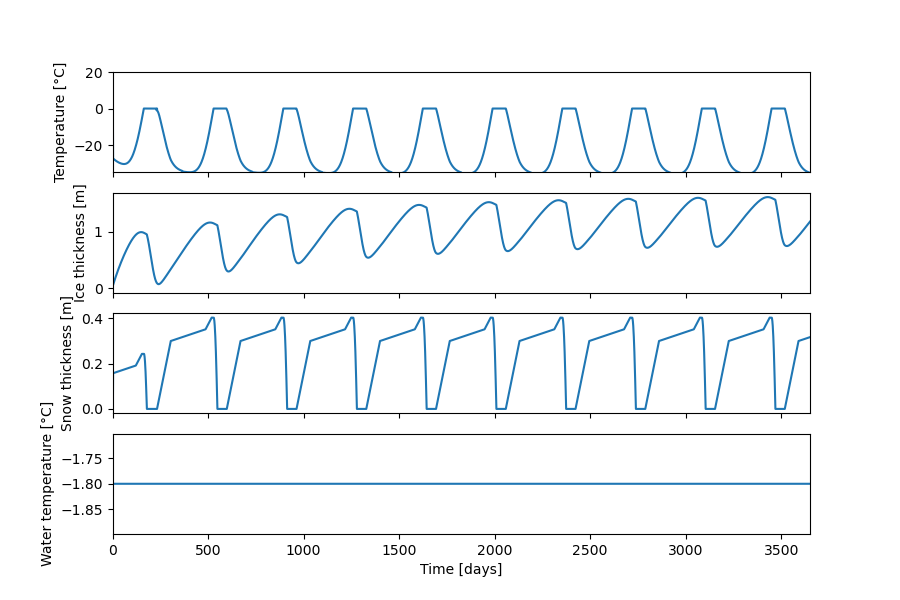

In [168]:
if True:
  # Plot temperature evolution
  fig, axes=plt.subplots(nrows=4, sharex=True, figsize=(9, 6))
  ax=axes[0]
  ax.plot(Tsurf-273.15)
  ax.set_xlim([0, days_total])
  ax.set_ylim([-35,20])
  #ax.set_xlabel('day')
  ax.set_ylabel('Temperature [°C]')

  # Plot ice-thickness evolution
  ax=axes[1]
  ax.plot(h_ice)
  ax.set_xlim([0, days_total])
  #ax.set_xlabel('day')
  ax.set_ylabel('Ice thickness [m]')
  
  # Plot snow-thickness evolution
  ax=axes[2]
  ax.plot(h_snow)
  ax.set_xlim([0, days_total])
  #ax.set_xlabel('day')
  ax.set_ylabel('Snow thickness [m]')
  
  # Plot water temperature
  ax=axes[3]
  ax.plot(T_water-273.15)
  ax.set_xlim([0, days_total])
  ax.set_xlabel('Time [days]')
  ax.set_ylabel('Water temperature [°C]')



Benutzt gerne auch die tools in der unteren linken ecke der Abbildungen, z.b. zum zoomen oder verschieben der linien. 

Ein paar Erklärungen zu den Variablen: 

-Die Temperatur (ganz oben) ist die Oberflächentemperatur des Eises/Schnees/... 

-Die Water Temperature ist die temperatur des wassers im direkten kontakt mit der unterseite des Eises (falls vorhanden).

Woher kommt das zickzack muster? 
Vergleiche die Oberflächentemperatur mit dem typischen temperaturen am Nordpol (google), Stimmen diese in etwa überein? Versuche den größten Unterschied zu erklären.
Wieso ist die Wassertemperatur meistens bei -1.8°C und nicht bei 0°C?
Was passiert am anfang mit der wasser Temperatur? Welchen einfluss hat diese besonderheit auf das Eis im folgenden Winter?



Ein fast 2D Meereismodell

Bisher haben wir eis an einem einzigen Ort simuliert, das könnte etwa eine messtation an der sybirischen küste sein. Für ein echtes 2D Eismodell der Arktis müssten wir insbesondere die Drift von dem Eis berücksichtigen die großen einfluss auf die Verteilung und das überleben vom Eis hat. Das können wir hier nicht leisten. Als ersten kleinen Schritt in Richtung eines 2D modells können wir allerdings versuchen die breitengradabhängigkeit der strahlung zu imitieren. Hatzianastassiou und andere haben in einem wiss. Artikel (https://acp.copernicus.org/articles/5/2847/2005/acp-5-2847-2005.pdf) die sonneneinstrahlung nahe der erdoberfläce simuliert und mit messdaten kombiniert. In Abbildung 3a (siehe unten) ist die Strahlungsstärke abhängig von der Breite (Latitude) and den Jahreszeiten dargestellt. Um keien externen daten einlesen zu müssen habe ich versucht eine Funktion zu basteln die ausreichend ähnliche ergebnisse liefert (quick and diry). Dieser Vorgang wird parameterisierung genannt wobei ein komplexer prozess wird durch eine einfache gleichung ersetzt wird. Meist wird dies gemacht weil der uhrsprüngliche prozess für eine anwendung nicht modelliert werden kann (oder soll) aber die wesentlichen auswirkungen nicht ignoriert werden können. 

Vergleicht die Abbildung aus der Literatur mit dem Plot den die folgende Zelle generiert und entscheided ob diese ausreichend gut überinstimmen. (Wer möchte kann es auch besser machen).


![](https://raw.githubusercontent.com/duschlamp/zerolayerSI/main/sw_lit.png)

<IPython.core.display.Javascript object>


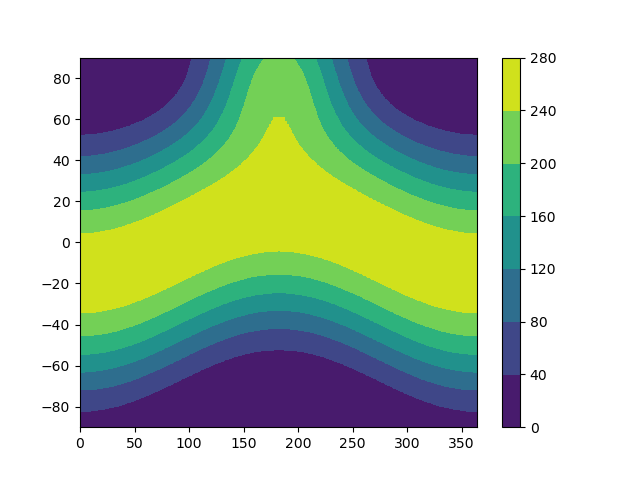

In [169]:
def shortwave(day, lat=80.):
    swAA=np.sin(day/365*np.pi)**6*np.sin(lat/180.*np.pi)**4
    if lat<0: swAA=0.
    sw=np.cos((lat-30.*np.sin(day/365*np.pi)**2+15.)/360.*2*np.pi)**2 +0.7* swAA
    sw=sw*270.
    return sw

#Original version for comparison   
#def shortwave(doy, lat='none'):
#    SW  = 314 * np.exp(-(doy-164.)**2/4608.)
#    return SW

#find/check parameterisation of fig 3a in https://acp.copernicus.org/articles/5/2847/2005/acp-5-2847-2005.pdf
#plt.figure()
lats=np.linspace(-90,90, 100)
doys=np.arange(365)
lats2d, doys2d=np.meshgrid(lats, doys)
sw2d=np.zeros_like(doys2d)

for i in range(len(doys)):
    for j in range(len(lats)):
        sw2d[i,j] = shortwave(doys2d[i,j], lat=lats2d[i,j])

#swAA=np.sin(doys2d/365*np.pi)**6*np.sin(lats2d/180.*np.pi)
#swAA[lats2d<0]=0.
#sw=np.cos((lats2d-30.*np.sin(doys2d/365*np.pi)**2+15.)/360.*2*np.pi)**2 +0.5* swAA
#sw=sw*265.
    
plt.figure()
plt.contourf(doys2d,lats2d, sw2d)
plt.colorbar()
    
    

    

Jetzt können können wir die alte version der funktion "def shortwave()...return sw" durch diese neue version ersetzen. Alle eingerückten Zeilen gehören zu der Funktion und müssen mitkopiert werden. Anschließend führt den ganzen code neu aus indem ihr auf Cell/Run All klickt. Könnt ihr Unterschiede zu den vorherigen ergebnissen sehen?

In [170]:
lats=np.linspace(40, 90, 51)
Tsurf_dayslats=np.zeros([days_total+1, len(lats)])
h_ice_dayslats=np.zeros([days_total+1, len(lats)])
h_snow_dayslats=np.zeros([days_total+1, len(lats)])
T_water_dayslats=np.zeros([days_total+1, len(lats)])

for i in range(len(lats)):
    Tsurf_dayslats[:,i], h_ice_dayslats[:,i], h_snow_dayslats[:,i], T_water_dayslats[:,i] = seaice_model(lats[i])


<IPython.core.display.Javascript object>


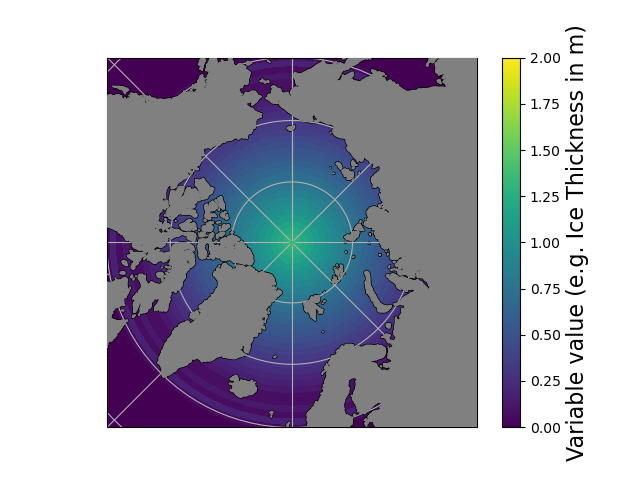

/home/dusch/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


In [172]:
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features

ref_crs=ccrs.NorthPolarStereo()

lon_map=(np.ones([360,len(lats)]).T*np.linspace(0,359, 360)).T
lat_map=np.ones([360,len(lats)])*lats

'''
Hier wird ausgewählt welche variable wir abbilden möchten. Den Ersten teil (np.ones()) können wir ignorieren.
Im hinteren Teil wählen wir eine der variablen aus (h_ice_dayslats, Tsurf_dayslats, h_snow_dayslats oder T_water_dayslats)
Die erste zahl in eckigen klammern gibt den Tag an (0=bevor die simulation los geht, 3650=10 jahre später)
Der ':' steht für alle werte in dieser richtung. hier bedeutet das alle Breitengrade. Es kann also auch so gelassen werden. 
'''

variable_map=np.ones([360,len(lats)]) * h_ice_dayslats[3286, :]


xyz_cci = ref_crs.transform_points(ccrs.PlateCarree(), lon_map, lat_map)
x_map=xyz_cci[:,:,0]
y_map=xyz_cci[:,:,1]

if 1:        
    plt.figure()
    ax = plt.axes(projection = ref_crs)  # create a set of axes with Mercator projection
    pcol=ax.pcolormesh(x_map, y_map, variable_map, vmin=0, vmax=2.)
    cbar=plt.colorbar(pcol)
    cbar.set_label('Variable value (e.g. Ice Thickness in m)',size=16)
    ax.add_feature(cf.LAND, color='gray', zorder=100)
    #ax.add_feature(cf.COASTLINE, color='lightgray')
    ax.gridlines(xlocs=np.linspace(-180, 180, 9), ylocs=np.linspace(0, 80, 9))
    ax.coastlines(linewidth=2)
    ax.set_xlim([-3.42e6, 3.42e6])
    ax.set_ylim([-3.42e6, 3.42e6])
    #ax.text(-3.2e6, 3.1e6, '2019-03-15', fontsize=13, c='w')

Die Abbildung oben zeigt die eisdicke nach 3286 tagen (hier hat ein Jahr genau 365 Tage, 9 Jahre= 3285 tage, Tag 3286 ist demnach ein 1. Januar). 

Wann erwrtet ihr dass es am wenigsten eis gibt? Stimmen eure erwartungen mit dem modell überein?

Ohne klimate action schlittern wir global auf bis zu 8.5W/m^2 zusätzlicher **longwave radiation** bis zum Jahre 2100 zu. In optimistischen scenarios (in etwa etsprechend 2° globaler Erwärmung) sind es nur 2.6W/m^2. In der Artis sind diese Zahlen deutlich höher (ca. doppelt so groß). Was verändert sich wenn ihr die longwave radiation entsprechend erhöt (Tip: die Funktion die ihr sucht ist in dem ersten code block)? Denkt daran code/run all zu benutzen nachdem ihr funktionen verändert, sonst wird nicht die aktualisierte verwendet.

Wenn die Menschen ihr Verhalten nicht ändern, wird es dann in diesem Jahrundert einen eisfreien Arktischen Ozean geben? In anderen Worten, findet ihr einen Tag an dem die Eisdicke überall 0 (oder sehr dicht an 0) ist? Wie sieht es bei geringerer Erderwährung aus?

Welchen Einfluss hat Schnee auf das eis? Was passiert z.b. wenn ihr die schneefallrate (snowfall()) halbiert?
